# Supplementary Figure 5. Seasonal precipitation and population dynamics with temperature

Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 08 Nov 22

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import json

### 1. Set up model
Parameters:

In [2]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

Initial conditions:
(equilibrium values previously defined in Supp)

In [3]:
O0 = 15947.608023052446
L0 = 40271.71074193975
P0 = 32.67541200187585
M0 = 228.72754035145144
F0 = 228.72754035145144

Seasonality functions:

In [4]:
with open("Rio.json", 'r') as f:
    score = json.load(f)  
    
def K(t):
    return score[round(t)]

In [7]:
with open("Rio_temp.json", 'r') as f:
    score = json.load(f)  
    
def KT(t):
    return score[round(t)]

Model:

In [8]:
def deriv_pre(y, t, phi, alphaO, muO, K, KT, AA, BB, alphaL, alphaP, muP, muM, muF):
    
    O, L, P, M, F = y
    
    #MOSQUITOES
        
    allmales = 1+M
    
    #Eggs
    dOdt = phi * F * M/allmales - alphaO*O - muO*O
    # eggs laid * total females * total males/ all males

    #Larvae
    dLdt =  alphaO*O - alphaL*L - muL*L
    
    #Pupae
    dPdt =  alphaL*(L/((1+(AA*K(t)*KT(t)*L))**BB)) - alphaP*P - muP*P
    
    #Adult
    dMdt =  0.5*alphaP*P - muM*M
    
    dFdt =  0.5*alphaP*P - muF*F    
    
    return dOdt, dLdt, dPdt, dMdt, dFdt

Model prerequisites:

In [9]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, L0, P0, M0, F0 # initial condition vector

Run model:

In [10]:
ret = odeint(deriv_pre, y0, t, args=(phi, alphaO, muO, K, KT, AA, BB, alphaL, alphaP, muP, muM, muF),hmax=1)

O, L, P, M, F = ret.T

### 2. Results
Format data:

In [12]:
pop = M+F
days = range(1501)
Bobo = np.genfromtxt(fname="Rio_long.txt") # import precipitation data
Bobo2 = sm.nonparametric.lowess(Bobo[:,1], Bobo[:,0], frac=0.8/3) # smooth the curve
prec = Bobo2[:,1]
month = Bobo2[:,0]
Zobo = np.genfromtxt(fname="Rio_temp_long.txt") # import precipitation data
Zobo2 = sm.nonparametric.lowess(Zobo[:,1], Zobo[:,0], frac=0.8/3) # smooth the curve
temp = Zobo[:,1]

t1 = days # weekly time points
t2 = month*30 # monthly time points
data0 = pop # adult mosquito population
data1 = prec # precipitation values
data2 = temp # temperature values

Plot results:

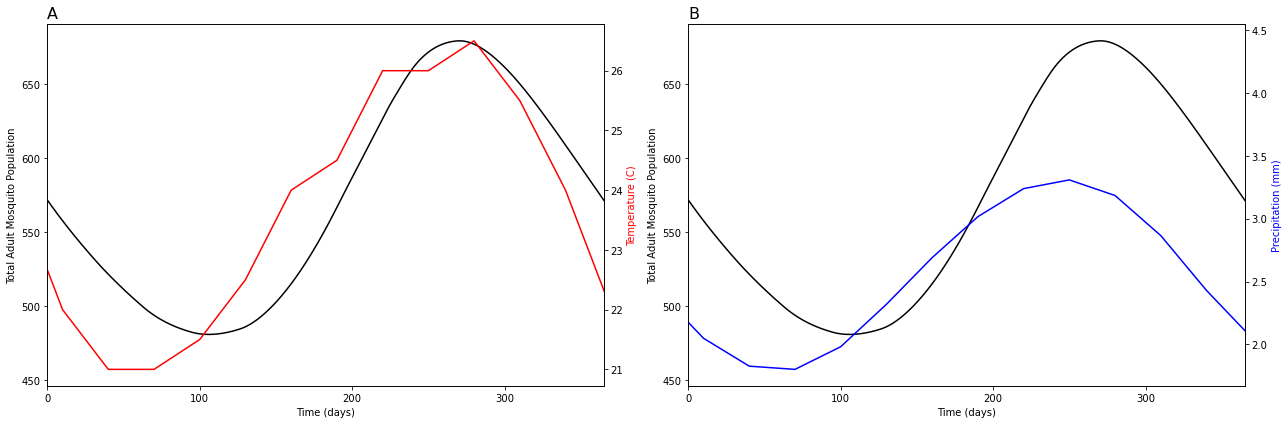

In [13]:
fig, ((ax3, ax1)) = plt.subplots(1, 2, figsize=(18, 6))


ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Total Adult Mosquito Population')
ax1.plot(t1, data0, color='black')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Precipitation (mm)', color='blue')
ax2.plot(t2, data1, color='blue')
ax1.set_xlim(500,865)

positions = (500, 600, 700, 800)
labels = ("0", "100", "200", "300")
ax1.set_xticks(positions, labels)
ax1.set_title("B", loc='left', fontdict={'fontsize':16})

#------------------------------

ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Total Adult Mosquito Population')
ax3.plot(t1, data0, color='black')
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax4.set_ylabel('Temperature (C)', color='red')
ax4.plot(t2, data2, color='red')
ax3.set_xlim(500,865)
ax3.set_title("A", loc='left', fontdict={'fontsize':16})

ax3.set_xticks(positions, labels)
fig.tight_layout()

#plt.savefig('SFigure5.jpeg', bbox_inches='tight', dpi = 300)

Calculate proportion increase from min to max and time lag from precipitation peak to population peak:

In [14]:
total = M+F
cut_total = total[183:548] # 183 -> 548 cut a year from down the middle
maxs = max(cut_total)
mins = min(cut_total)
maxs_position = [i for i, j in enumerate(cut_total) if j == maxs]
maxs_position # 235 of 365

[223]

In [15]:
cut_prec = prec[6:18] # 6 -> 18 cut a year from down the middle
maxs_prec = max(cut_prec)
maxs_prec_position = [i for i, j in enumerate(cut_prec) if j == maxs_prec]
maxs_prec_position # 12 of 24

[6]

In [16]:
maxs_position[0] - (maxs_prec_position[0]*30) # 43-day lag from precipitation peak to population peak

43

In [17]:
maxs/mins # 1.41-fold increase 

1.4125450951585536

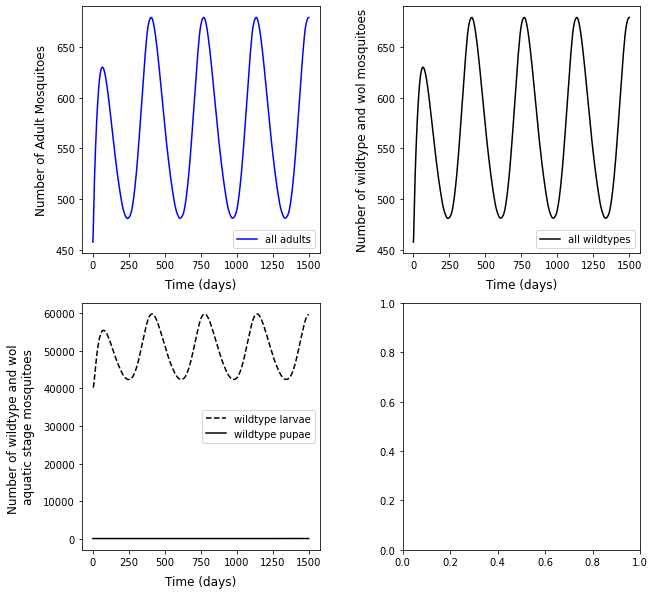

In [18]:
# check dynamics look reasonable

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+M, 'blue', label='all adults')
ax1.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes", fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes", fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.set_xlabel("Time (days)", fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes", fontsize=12, labelpad=8)
ax3.legend()

#ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
#plt.xticks([150,200,250,300,350,400])
#ax4.set_xlabel("Time (days)", fontsize=12, labelpad=8)
#ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia", fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)